Clone Hack Repo

In [1]:
!git clone https://github.com/ZoneLikeWonderland/HACK-Model.git
!mv HACK-Model/* ./

Cloning into 'HACK-Model'...
remote: Enumerating objects: 28, done.
remote: Total 28 (delta 0), reused 0 (delta 0), pack-reused 28
Receiving objects: 100% (28/28), 47.38 MiB | 22.63 MiB/s, done.


Put your username and password to "**USERNAME_HERE**" and "**PASSWORD_HERE**"

In [2]:
!wget --post-data "username=USERNAME_HERE&password=PASSWORD_HERE" 'https://download.is.tue.mpg.de/download.php?domain=flame&sfile=TextureSpace.zip&resume=1' -O './TextureSpace.zip' --no-check-certificate --continue
!unzip TextureSpace.zip

--2023-08-23 10:51:47--  https://download.is.tue.mpg.de/download.php?domain=flame&sfile=TextureSpace.zip&resume=1
Resolving download.is.tue.mpg.de (download.is.tue.mpg.de)... 192.124.27.139
Connecting to download.is.tue.mpg.de (download.is.tue.mpg.de)|192.124.27.139|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: download.php?domain=flame&sfile=TextureSpace.zip&resume=1 [following]
--2023-08-23 10:51:48--  https://download.is.tue.mpg.de/download.php?domain=flame&sfile=TextureSpace.zip&resume=1
Reusing existing connection to download.is.tue.mpg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 1158570802 (1.1G) [application/octet-stream]
Saving to: ‘./TextureSpace.zip’

./TextureSpace.zip  100%[===================>]   1.08G  7.07MB/s    in 2m 0s   

2023-08-23 10:53:48 (9.21 MB/s) - ‘./TextureSpace.zip’ saved [1158570802/1158570802]

Archive:  TextureSpace.zip
  inflating: FLAME_texture.npz       
  inflating: Readme.pdf              


In [3]:
!pip install roma
!pip install trimesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.5/686.5 kB 5.3 MB/s eta 0:00:00


In [4]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=7432050f176de54705b970508b74fc4d8b3ae4b648e14152f44012e858643635
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31530 sha256=4ee8e873762f0af6990566924096ea33f669b0e1b68785f8944ea3481852b2b6
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu118_pyt201/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 33.6 MB/s eta 0:00:00


In [8]:
%matplotlib inline
import numpy as np
import cv2 as cv
import os
import sys
import tqdm
import hack_model
import helper
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.ops import knn_points, knn_gather
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)
import pytorch3d
from pytorch3d.io import load_obj
from pytorch3d.renderer.mesh import rasterize_meshes
from pytorch3d.renderer import TexturesUV
import trimesh
from pytorch3d.vis.plotly_vis import plot_scene
from pytorch3d.renderer import (look_at_view_transform,
                                FoVPerspectiveCameras,
                                FoVOrthographicCameras,
                                MeshRenderer,
                                MeshRasterizer,
                                RasterizationSettings,
                                SoftPhongShader,
                                HardPhongShader,
                                SoftGouraudShader,
                                HardGouraudShader,
                                TexturesVertex,
                                PointLights)
import torch
from tqdm.notebook import tqdm
device = torch.device("cpu")

Download flame_template.npz and head_template_mesh.obj and put them in root folder. You can download it from [FLAME_TO_HACK](https://github.com/aoru45/FLAME_TO_HACK)



In [9]:
flame_npz = np.load("./flame_template.npz")
flame_verts = flame_npz["vtx"]
flame_faces = flame_npz["faces"]
flame_lmk_face_idx = torch.LongTensor(np.array(flame_npz["lmk_face_idx"], dtype = np.int64)).to(device)
flame_lmk_b_coords = torch.tensor(flame_npz["lmk_b_coords"], dtype = torch.float32).to(device)
# flame_ldm_idx = torch.LongTensor([])
# hack_ldm_idx = torch.LongTensor([])
flame_mesh = Meshes(verts = [torch.tensor(flame_verts)], faces = [torch.LongTensor(flame_faces)]).to(device)
hack = hack_model.HACK().to(device)

S = hack_model.load_pca(r"model/S.npy").to(device)
E = hack_model.load_pca(r"model/E.npy").to(device)
P = hack_model.load_pca(r"model/P.npy").to(device)



Init scale and offset, draw the pointcloud to see the corase difference.

tensor([-5.5689e-05,  7.1139e-04, -5.4429e-02])


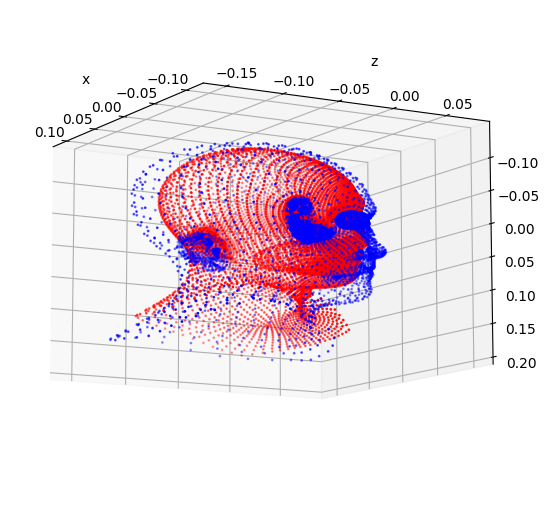

In [10]:
def plot_pointcloud(points, title=""):
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y, c="b")
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    fig.add_axes(ax)
    plt.show()
import random
def plot_mesh2(mesh1, mesh2, title=""):
    points1 = mesh1.verts_padded()
    points2 = mesh2.verts_padded()
    x1, y1, z1 = points1.clone().detach().cpu().squeeze().unbind(1)
    x2, y2, z2 = points2.clone().detach().cpu().squeeze().unbind(1)

    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x1, z1, -y1, c="b",s=1)
    ax.scatter3D(x2, z2, -y2, c="r",s=1)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    dir = random.choice([30, 60, 90, 120])
    ax.view_init(170, dir)
    fig.add_axes(ax)
    plt.show()

beta_zero = torch.zeros(1, 200).to(device)
theta_zero = torch.zeros(1, 8, 3).to(device)
tau_zero = torch.zeros(1, 1).to(device) # - 0.1
alpha_zero = torch.ones(1, 1).to(device)
bsw_zero = torch.zeros(1, 55).to(device)

hack_faces = torch.LongTensor(hack_model.obj_template.fvs).to(device)
with torch.no_grad():
  hack_verts = hack(theta_zero, tau_zero, alpha_zero, bsw_zero, T=S(beta_zero), E=E(), P=P())["T_transformed"][0]
hack_mesh = Meshes(verts = [hack_verts], faces = [hack_faces])
v1 = hack_mesh.verts_padded()
v2 = flame_mesh.verts_padded()
def size_(v):
  tl, _ = torch.max(v[0], dim = 0)
  br, _ = torch.min(v[0], dim = 0)
  return tl - br
scale_init = size_(v2) / size_(v1)
hack_mesh_scaled = hack_mesh.scale_verts(scale_init)
offset_init = flame_mesh.verts_padded()[0].mean(dim = 0) - hack_mesh_scaled.verts_padded()[0].mean(dim = 0)
hack_mesh_scaled.offset_verts_(offset_init)
print(offset_init)
# hack_mesh, _ = normalize_mesh(hack_mesh)
# plot_pointcloud(hack_verts[None], "hack")
# plot_pointcloud(torch.tensor(flame_verts)[None], "flame")
plot_mesh2(flame_mesh, hack_mesh_scaled)
# print(flame_verts.max(), flame_verts.min(), flame_verts.shape)




Prepare some 3D landmarks.

In [11]:
# landmarks
def vertices2landmarks(vertices, faces, lmk_faces_idx, lmk_bary_coords):
  batch_size, num_verts = vertices.shape[:2]
  device = vertices.device
  lmk_faces = torch.index_select(faces, 0, lmk_faces_idx.view(-1)).view(
      batch_size, -1, 3)
  lmk_faces += torch.arange(
      batch_size, dtype=torch.long, device=device).view(-1, 1, 1) * num_verts
  lmk_vertices = vertices.view(-1, 3)[lmk_faces].view(
      batch_size, -1, 3, 3)
  landmarks = torch.einsum('blfi,blf->bli', [lmk_vertices, lmk_bary_coords])
  return landmarks
def select_landmark3d68(vertices, faces, lmk_faces_idx, lmk_bary_coords):
  landmarks3d = vertices2landmarks(vertices, faces,
                                       lmk_faces_idx.unsqueeze(0).repeat(vertices.shape[0], 1),
                                       lmk_bary_coords.unsqueeze(0).repeat(vertices.shape[0], 1, 1))
  return landmarks3d
flame_ldms = select_landmark3d68(flame_mesh.verts_padded(),flame_mesh.faces_packed(),flame_lmk_face_idx,flame_lmk_b_coords)
# print(flame_ldms.shape)

hack_ldms_idx = [1225, 1888, 1052, 367, 1719, 1722, 2199, 1447, 966, 3661, 4390, 3927, 3924, 2608, 3272, 4088, 3443, 268, 493, 1914, 2044, 1401, 3615, 4240, 4114, 2734, 2509, 978, 4527, 4942, 4857, 1140, 2075, 1147, 4269, 3360, 1507, 1542, 1537, 1528, 1518, 1511, 3742, 3751, 3756, 3721, 3725, 3732, 5708, 5695, 2081, 0, 4275, 6200, 6213, 6346, 6461, 5518, 5957, 5841, 5702, 5711, 5533, 6216, 6207, 6470, 5517, 5966]
hack_ldms_idx = hack_ldms_idx[17:]
hack_ldms_idx = torch.tensor(hack_ldms_idx, dtype = torch.long).to(device)


Prepare some training parameters.

In [12]:
# flame_mesh, (flame_offset, flame_scale) = normalize_mesh(flame_mesh)
beta = torch.nn.Parameter(torch.randn(1,200).to(device))
scale = torch.nn.Parameter(scale_init.clone().unsqueeze(0).to(device))
offset_p = torch.nn.Parameter(offset_init.clone().unsqueeze(0).to(device))
theta = torch.nn.Parameter(torch.zeros(1, 8, 3).to(device))
# theta = torch.zeros(1, 8, 3).to(device)
tau = torch.zeros(1, 1).to(device) # - 0.1
alpha = torch.ones(1, 1).to(device)
bsw = torch.zeros(1, 55).to(device)
# bsw = torch.nn.Parameter(torch.zeros(1,55).to(device))
# optimizer = torch.optim.Adam(params = [beta])
optimizer = torch.optim.AdamW([beta,theta, scale, offset_p], lr=1e-4, amsgrad=True)
with torch.no_grad():
  zero_vts = hack(theta, tau, alpha, bsw, T=S(beta_zero), E=E(), P=P())["T_transformed"][0]
zero_mesh = Meshes(verts = [zero_vts], faces = [hack_faces])
distance_judge = 0.0001
num_epoch = 10
num_iter = 300
ldm_weight = 1
verts_weight = 0.01

Train form some epochs. It is used to fit the HACK shape to FLAME's mean shape.

  0%|          | 0/300 [00:00<?, ?it/s]

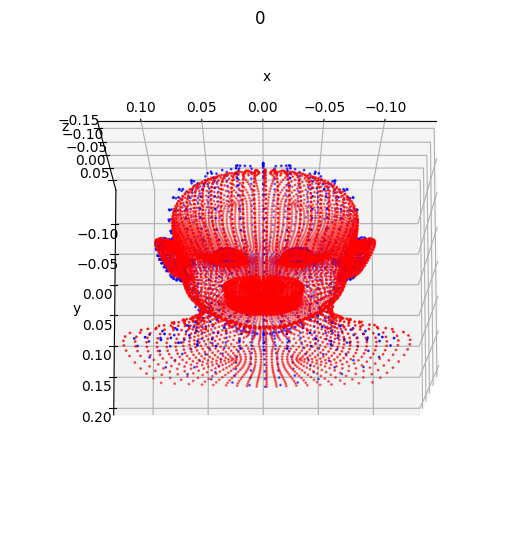

  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [13]:
for epoch in range(num_epoch):
  loop = tqdm(range(num_iter))
  for _iter in loop:
    optimizer.zero_grad()
    # (B,N,3)
    offset = hack(theta, tau, alpha, bsw, T=S(beta), E=E(), P=P())["T_transformed"][0]
    deformed_mesh = zero_mesh.detach().offset_verts(offset)
    deformed_mesh.scale_verts_(scale)
    op = offset_p.repeat(offset.shape[0], 1)
    deformed_mesh.offset_verts_(op)

    deformed_verts = deformed_mesh.verts_padded()
    target_verts = flame_mesh.verts_padded().detach()

    # verts loss, target_verts have more verts
    knn = knn_points(target_verts, deformed_verts)
    nearest_verts = knn_gather(deformed_verts, knn.idx)[:,:,0] # TODO

    # (B,N,3)
    distance = torch.sum((target_verts - nearest_verts)**2, dim = 2)
    mask = (distance<distance_judge).float().detach()
    # ldm
    deformed_ldms = torch.index_select(deformed_verts[0], 0, hack_ldms_idx) # (n,3)
    loss_ldm = torch.nn.functional.mse_loss(deformed_ldms, flame_ldms[0])
    loss_verts = (mask * distance).mean()
    # loss_laplacian = mesh_laplacian_smoothing(deformed_mesh, method="uniform")
    loss = loss_ldm * ldm_weight + loss_verts * verts_weight # + loss_laplacian * laplacian_weight

    loop.set_description(f"[Loss: {loss:.6f}] [ldm: {loss_ldm:.6f}] [verts: {loss_verts:.6f}]")
    loss.backward()
    optimizer.step()
  plot_mesh2(flame_mesh, deformed_mesh, f"{epoch}")

Prepare FLAME texture.

In [14]:
# FLAME Texture
tex_params = 50
tex_space = np.load("FLAME_texture.npz")
texture_mean = tex_space['mean'].reshape(1, -1)
texture_basis = tex_space['tex_dir'].reshape(-1, 200)
num_components = texture_basis.shape[1]
texture_mean = torch.from_numpy(texture_mean).float()[None,...]
texture_basis = torch.from_numpy(texture_basis[:,:50]).float()[None,...]
texture_mean = texture_mean.reshape(-1, 512, 512, 3)# .permute(0,3,1,2) # (1,3,512,512)
texture_basis = texture_basis.reshape(-1,512,512,3,tex_params) # .permute(0,4,3,1,2) # (1,50,3,512,512)
# FLAME obj
flame_verts_, flame_faces_, flame_aux = load_obj("head_template_mesh.obj")
flame_vts = flame_aux.verts_uvs[None, ...]  # (N, V, 2)
flame_fvts = flame_faces_.textures_idx[None, ...]  # (N, F, 3)


/usr/local/lib/python3.10/dist-packages/pytorch3d/io/obj_io.py:548: UserWarning: Mtl file does not exist: template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [15]:
def face_vertices(vertices, faces):
  """
  :param vertices: [batch size, number of vertices, 3]
  :param faces: [batch size, number of faces, 3]
  :return: [batch size, number of faces, 3, 3]
  """
  assert (vertices.ndimension() == 3)
  assert (faces.ndimension() == 3)
  assert (vertices.shape[0] == faces.shape[0])
  assert (vertices.shape[2] == 3)
  assert (faces.shape[2] == 3)

  bs, nv = vertices.shape[:2]
  bs, nf = faces.shape[:2]
  device = vertices.device
  faces = faces + (torch.arange(bs, dtype=torch.int32).to(device) * nv)[:, None, None]
  vertices = vertices.reshape((bs * nv, 3))
  # pytorch only supports long and byte tensors for indexing
  return vertices[faces.long()]
def barycentric_coords(a, b, c, q):
  # a(n, 3)
  v1 = b-a
  v2 = c-a
  n = torch.cross(v1, v2)
  n_dot_n = torch.sum(n*n, dim=-1)
  w = q - a
  gamma = torch.sum(torch.cross(v1, w)*n, dim=-1)/n_dot_n
  beta = torch.sum(torch.cross(w, v2)*n, dim=-1)/n_dot_n
  alpha = 1.0-beta-gamma
  return torch.stack([alpha, beta, gamma], dim = 1)

def pixel_to_3d(vertices, faces, image_size = 512):
  # vertices (B, V, 3)
  # faces (B, F, 3)
  fixed_vertices = vertices.clone()
  fixed_vertices[..., :2] = fixed_vertices[..., :2] / image_size
  fixed_vertices[..., 0] = -fixed_vertices[..., 0]
  meshes_screen = Meshes(verts=fixed_vertices.float(), faces=faces.long())
  pix_to_face, zbuf, bary_coords, dists = rasterize_meshes(
      meshes_screen,
      image_size=image_size,
      blur_radius=0,
      faces_per_pixel=1,
      bin_size=None,
      max_faces_per_bin=None
  )
  vismask = (pix_to_face > -1).float()
  mask = pix_to_face == -1
  # pix_to_face: (N, image_size, image_size, 1)
  pix_to_face = pix_to_face.clone()
  pix_to_face[mask] = 0
  # torch.Size([262144, 3])
  idx = pix_to_face.flatten()
  pixel_face_idx = torch.index_select(faces.view(-1,3),0, idx) #(n, 3)

  p1 = torch.index_select(vertices.view(-1,3), 0, pixel_face_idx[:, 0])
  p2 = torch.index_select(vertices.view(-1,3), 0, pixel_face_idx[:, 1])
  p3 = torch.index_select(vertices.view(-1,3), 0, pixel_face_idx[:, 2])
  pixel_face_pt = torch.stack([p1, p2, p3], dim =1) #(-1,3,3)

  # pixel_face_idx = faces.view(-1, 3).gather(0,idx).view(-1,3,1).repeat(1,1,3) # (-1, 3, 3)
  # pixel_face_pt = vertices.view(-1,1,3).repeat(1,3,1).gather(0, pixel_face_idx) # (-1, 3, 3)
  # print("vertices", vertices[...,0].max(), vertices[...,0].min())
  # print("pixel_face_pt", pixel_face_pt[..., 0].max(), pixel_face_pt[..., 0].min())
  # bary_coords (N, image_size, image_size, faces_per_pixel, 3)
  pixel_face_pt_interp = (pixel_face_pt * bary_coords.view(-1,3,1)).sum(1)
  pixel_face_pt_interp = pixel_face_pt_interp.view(-1, image_size, image_size, 3)

  return pixel_face_pt_interp, vismask
def render_test(vertices, faces, uv_vertices, uv_faces, uv_image, image_size = 512):
  # OK
  # vertices (B, V, 3)
  # faces (B, F, 3)
  fixed_vertices = vertices.clone()
  fixed_vertices[..., :2] = fixed_vertices[..., :2] / image_size
  fixed_vertices[..., 0] = -fixed_vertices[..., 0]
  meshes_screen = Meshes(verts=fixed_vertices.float(), faces=faces.long())
  pix_to_face, zbuf, bary_coords, dists = rasterize_meshes(
      meshes_screen,
      image_size=image_size,
      blur_radius=0,
      faces_per_pixel=1,
      bin_size=None,
      max_faces_per_bin=None
  )
  vismask = (pix_to_face > -1).float()
  mask = pix_to_face == -1
  # pix_to_face: (N, image_size, image_size, 1)
  pix_to_face = pix_to_face.clone()
  pix_to_face[mask] = 0
  # torch.Size([262144, 3])
  idx = pix_to_face.flatten()

  pixel_face_idx = torch.index_select(faces.view(-1,3),0, idx) #(n, 3)

  uv_face_idx = torch.index_select(uv_faces.view(-1,3), 0, idx)

  p1 = torch.index_select(uv_vertices[0], 0, uv_face_idx[:, 0]) #(n,2)
  p2 = torch.index_select(uv_vertices[0], 0, uv_face_idx[:, 1]) #(n,2)
  p3 = torch.index_select(uv_vertices[0], 0, uv_face_idx[:, 2]) #(n,2)
  p = torch.stack([p1, p2, p3], dim = 1) # (b,3,2)
  p_interp = (p * bary_coords.view(-1,3,1)).sum(1)
  grid = p_interp.view(-1, image_size, image_size, 2)
  grid = grid * 2 - 1
  grid[...,1] = -grid[..., 1]

  output = torch.nn.functional.grid_sample(uv_image.permute(0,3,1,2),
                                           grid,
                                           mode='bilinear',
                                           padding_mode="border",
                                           align_corners=False)

  return output




def get_color_with_3d(pts, vertices, faces, uv_vertices, uv_faces, uv_image):
  H, W = uv_image.shape[1:3]
  # uv image (B, H, W, C)
  # get nearest face with pts
  points = pts.view(-1,3)
  points_first_idx = torch.LongTensor([0]).to(device)
  tris = face_vertices(vertices, faces)[0] # (F,3,3)
  tris_first_idx = points_first_idx
  # 1. (arg0: torch.Tensor, arg1: torch.Tensor, arg2: torch.Tensor, arg3: torch.Tensor, arg4: int, arg5: float)
  dists, near_face_idxs = pytorch3d._C.point_face_dist_forward(points,
                                                               points_first_idx,
                                                               tris,
                                                               tris_first_idx,
                                                               points.shape[0],
                                                               5e-3
                                                       )

  # near_face_idxs  (p)
  near_faces_uv = uv_faces[0][near_face_idxs] #(N,3)
  near_faces = faces[0][near_face_idxs] #(N,3)

  # face pts
  fp1 = torch.index_select(vertices[0], 0, near_faces[:, 0]) #(n,3)
  fp2 = torch.index_select(vertices[0], 0, near_faces[:, 1]) #(n,3)
  fp3 = torch.index_select(vertices[0], 0, near_faces[:, 2]) #(n,3)
  w = barycentric_coords(fp1, fp2, fp3, points) # (n, 3)

  #w_mask = torch.ones(w.shape[0], dtype = torch.bool).to(device)
  w_mask = (w[:, 0]>=0) & (w[:, 0]<=1) &  (w[:, 1]>=0) & (w[:, 1]<=1) & (w[:, 2]>=0) & (w[:, 2]<=1)
  # print(w_mask)
  w_valid_idx = torch.arange(w_mask.shape[0]).to(device)[w_mask]
  print("b_mask", w_valid_idx.shape, w_mask.shape)

  # uv pts
  p1 = torch.index_select(uv_vertices[0], 0, near_faces_uv[:, 0])[w_valid_idx] #(n,2)
  p2 = torch.index_select(uv_vertices[0], 0, near_faces_uv[:, 1])[w_valid_idx] #(n,2)
  p3 = torch.index_select(uv_vertices[0], 0, near_faces_uv[:, 2])[w_valid_idx] #(n,2)

  # (n, 2)
  grid = torch.ones((points.shape[0]), 2).to(device) * 2

  # (nv, 2)
  uvp_valid = w[w_valid_idx][:, 0:1] * p1 + w[w_valid_idx][:, 1:2] * p2 + w[w_valid_idx][:, 2:3] * p3
  # uvp_valid = (p1+p2+p3) / 3.
  uvp_valid = uvp_valid * 2 - 1
  uvp_valid[:, 1] = - uvp_valid[:, 1]
  # print(uvp_valid[:, 1].min(), uvp_valid[:, 1].max())
  grid[w_valid_idx] = uvp_valid

  output = torch.nn.functional.grid_sample(uv_image.permute(0,3,1,2),
                                           grid.view(-1, H, W, 2),
                                           mode='bilinear',
                                           padding_mode="border",
                                           align_corners=False)
  return output





Render HACK with FLAME Texture. Until now, we haven't converted HACK to FLAME, just use FLAME Texture using knn to get it's corresponding texture color.

b_mask torch.Size([68726]) torch.Size([262144])
tensor(74902.)


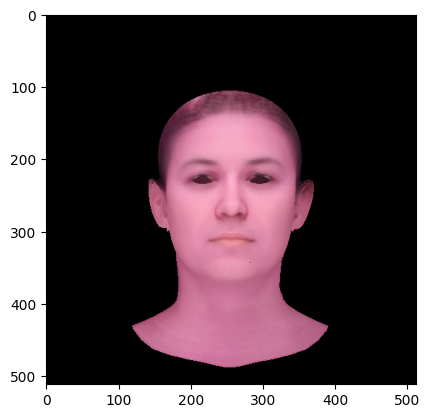

In [16]:
faces_uvs = trimesh.geometry.triangulate_quads(hack_model.obj_template.fvts)
faces_uvs = torch.LongTensor(faces_uvs).to(device)
verts_uvs = torch.Tensor(hack_model.obj_template.vts).to(device)
faces = trimesh.geometry.triangulate_quads(hack_model.obj_template.fvs)
faces = torch.LongTensor(faces).to(device)
tex = TexturesUV(maps = texture_mean[:,:,:, [2,0,1]].to(device)/ 255.,
                 faces_uvs = faces_uvs.unsqueeze(0),
                 verts_uvs = verts_uvs.unsqueeze(0))

scaled_verts = deformed_mesh.detach().verts_padded().clone()
scaled_verts[...,0] *= 2500
scaled_verts[...,1] *= 2500
scaled_verts[:,:,2] = -scaled_verts[:,:,2] + 10

flame_scaled_verts = torch.tensor(flame_verts).unsqueeze(0).to(device)
flame_scaled_verts[...,0] *= 2500
flame_scaled_verts[...,1] *= 2500
flame_scaled_verts[:,:,2] = -flame_scaled_verts[:,:,2] + 10

"""
# test original render result
tmp_color = render_test(flame_scaled_verts,
                        torch.LongTensor(flame_faces).unsqueeze(0).to(device),
                        flame_vts.to(device),
                        flame_fvts.to(device),
                        texture_mean[:,:,:, [2,0,1]].to(device)/ 255
                        )
"""
"""
# test flame render result
pixel_3d_pts, mask_ = pixel_to_3d(vertices = flame_scaled_verts, faces = torch.LongTensor(flame_faces).unsqueeze(0).to(device))
"""

# render HACK with FLAME texture by find nearest face with given points
pixel_3d_pts, mask_ = pixel_to_3d(vertices = scaled_verts, faces = faces.unsqueeze(0))
tmp_color = get_color_with_3d(pixel_3d_pts,
                              flame_scaled_verts,
                              torch.LongTensor(flame_faces).unsqueeze(0).to(device),
                              flame_vts.to(device), flame_fvts.to(device),
                              texture_mean[:,:,:, [2,0,1]].to(device)/ 255)
# print(pixel_3d_pts[...,0].min(), pixel_3d_pts[...,0].max())
# print(pixel_3d_pts[...,1].min(), pixel_3d_pts[...,1].max())
# print(pixel_3d_pts[...,2].min(), pixel_3d_pts[...,2].max())
print(torch.sum(mask_))
tmp_img = tmp_color[0].permute(1,2,0).cpu().numpy()
plt.figure()
plt.imshow(tmp_img)
plt.show()


Convert HACK's UV coordinate to the nearest FLAME's UV coordinate, then we can use these coordinates to render without knn process, because we have changed the UV coordinate itself.

In [37]:
def convert_(h_vs, h_fs, h_fvts, f_vs, f_fs, f_vts, f_fvts):
  hack_face_verts = face_vertices(h_vs, h_fs)
  num_faces = hack_face_verts.size(1)
  hack_face_verts = hack_face_verts.contiguous().view(-1, 3)
  points_first_idx = torch.LongTensor([0]).to(device)
  tris = face_vertices(f_vs, f_fs)[0] # (F,3,3)
  tris_first_idx = points_first_idx
  # 1. (arg0: torch.Tensor, arg1: torch.Tensor, arg2: torch.Tensor, arg3: torch.Tensor, arg4: int, arg5: float)
  dists, near_face_idxs = pytorch3d._C.point_face_dist_forward(hack_face_verts,
                                                               points_first_idx,
                                                               tris,
                                                               tris_first_idx,
                                                               hack_face_verts.shape[0],
                                                               5e-3
                                                         )


  # near_face_idxs  (p)
  near_faces_uv = f_fvts[0][near_face_idxs] #(N,3)
  near_pts = torch.index_select(tris, 0, near_face_idxs) # (N, 3, 3)

  fp1 = near_pts[:, 0]; fp2 = near_pts[:, 1]; fp3 = near_pts[:, 2]

  w = barycentric_coords(fp1, fp2, fp3, hack_face_verts) # (N, 3)
  w_mask = (w[:, 0]>=0) & (w[:, 0]<=1) &  (w[:, 1]>=0) & (w[:, 1]<=1) & (w[:, 2]>=0) & (w[:, 2]<=1)
  # w_mask = torch.ones((w.size(0)), dtype= torch.bool).to(device)

  w_valid_idx = torch.arange(w_mask.shape[0]).to(device)[w_mask]
  w_invalid_idx = torch.arange(w_mask.shape[0]).to(device)[~w_mask]
  print("b_mask", w_valid_idx.shape, w_mask.shape)

  # uv pts
  p1 = torch.index_select(f_vts[0], 0, near_faces_uv[:, 0]) #(n,2)
  p2 = torch.index_select(f_vts[0], 0, near_faces_uv[:, 1]) #(n,2)
  p3 = torch.index_select(f_vts[0], 0, near_faces_uv[:, 2]) #(n,2)

  out_uv = torch.zeros((hack_face_verts.size(0), 2)).to(device) # (N, 2)
  uvp_valid = w[w_valid_idx][:, 0:1] * p1[w_valid_idx] + \
   w[w_valid_idx][:, 1:2] * p2[w_valid_idx] + w[w_valid_idx][:, 2:3] * p3[w_valid_idx]
  uvp_invalid = (p1[w_invalid_idx] + p2[w_invalid_idx] + p3[w_invalid_idx]) / 3
  out_uv[w_mask] = uvp_valid # (N, 2)
  out_uv[~w_mask] = uvp_invalid
  return out_uv.view(-1, num_faces, 3, 2)

faces_uv_ = convert_(scaled_verts, faces.unsqueeze(0), faces_uvs.unsqueeze(0),
         flame_scaled_verts, torch.LongTensor(flame_faces).unsqueeze(0).to(device),
         flame_vts.to(device), flame_fvts.to(device)
         )
"""
faces_uv_ = convert_(deformed_mesh.detach().verts_padded().clone() * 2500, faces.unsqueeze(0), faces_uvs.unsqueeze(0),
         torch.tensor(flame_verts).unsqueeze(0).to(device) * 2500,
         torch.LongTensor(flame_faces).unsqueeze(0).to(device),
         flame_vts.to(device), flame_fvts.to(device)
)
"""
new_verts_uvs = verts_uvs.clone() # (n,2)
for i in range(faces_uv_.size(1)):
  idxs = faces_uvs[i]
  new_verts_uvs[idxs[0]] = faces_uv_[0][i][0]
  new_verts_uvs[idxs[1]] = faces_uv_[0][i][1]
  new_verts_uvs[idxs[2]] = faces_uv_[0][i][2]




b_mask torch.Size([82338]) torch.Size([84204])


In [38]:
tex_new = TexturesUV(maps = texture_mean[:,:,:, [2,0,1]].to(device)/ 255.,
                 faces_uvs = faces_uvs.unsqueeze(0),
                 verts_uvs = new_verts_uvs.unsqueeze(0))

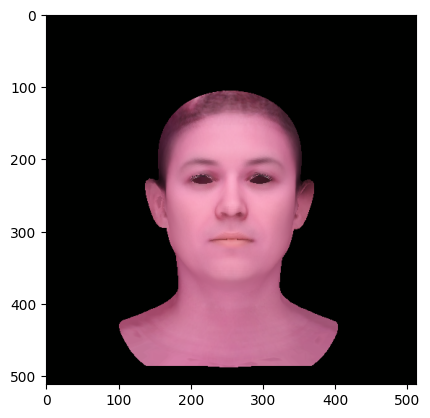

In [41]:
final_mesh = Meshes(verts = scaled_verts,
                    faces = faces.unsqueeze(0),
                    textures = tex_new)
image = render_test(scaled_verts,
                        faces.unsqueeze(0).to(device),
                        new_verts_uvs.unsqueeze(0),
                        faces_uvs.unsqueeze(0),
                        texture_mean[:,:,:, [2,0,1]].to(device)/ 255
                        )[0].permute(1,2,0).cpu().numpy()
plt.imshow(image)
plt.show()
